# Train Whale Detection

In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split

#Classes
from utils import RoboflowHelper
#Functions
from utils import calculate_bounding_box, crop_image, find_rotation_angle, rotate_image, centre_image

## Read Data

In [2]:
# Path to the image directory and CSV file
image_dir = "./data/imgs"
csv_file = "./data/train.csv"

# Reading the CSV file using Pandas
data = pd.read_csv(csv_file)

In [3]:
data.head()

,Image,whaleID
0,w_7812.jpg,whale_48813
1,w_4598.jpg,whale_09913
2,w_3828.jpg,whale_45062
3,w_8734.jpg,whale_74162
4,w_3251.jpg,whale_99558


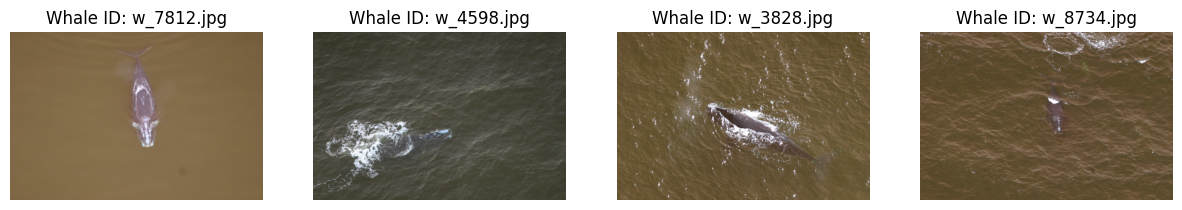

In [4]:
# Display the first four images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    image_name = data['Image'].values[i]
    image_path = os.path.join(image_dir, image_name)
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Whale ID: {image_name}")
        axes[i].axis('off')

plt.show()

## Import pretrained YOLOv5 Model

In [5]:
rfh = RoboflowHelper()

loading Roboflow workspace...
loading Roboflow project...


### Display Boundingboxes

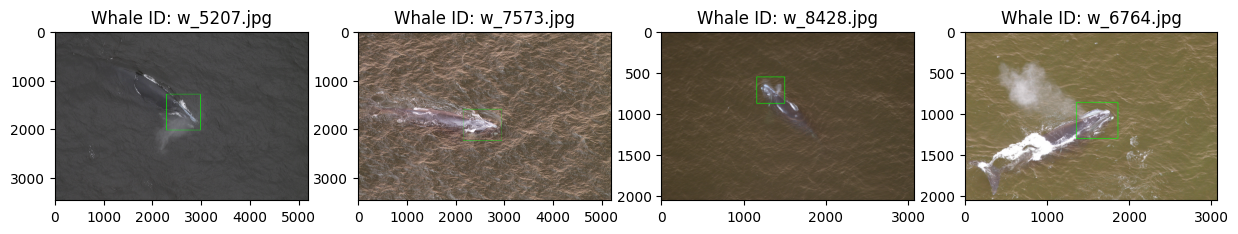

In [6]:
# Display the first four images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    # visualize your prediction
    index = 300 + i
    image_name = data['Image'].values[index]
    image_path = os.path.join(image_dir, data['Image'][index])
    prediction = rfh.get_prediction(image_path)
    if prediction:
        image = cv2.imread(image_path)
        start_point, end_point = calculate_bounding_box(prediction['x'], prediction['y'], prediction['width'], prediction['height'])
        cv2.rectangle(image, start_point, end_point, color=(0,255,0), thickness=6)
        axes[i].imshow(image)
        axes[i].set_title(f"Whale ID: {image_name}")

plt.show()

### Read Annotaded Data

In [7]:
with open("./data/annotations/headtips.json") as f:
    headtips = json.load(f)

with open("./data/annotations/blowholes.json") as f:
    blowholes = json.load(f)

In [8]:
headtips[0]

{'annotations': [{'class': 'point',
   'x': 1361.8785425101214,
   'y': 864.3886639676114}],
 'class': 'image',
 'filename': 'w_1.jpg'}

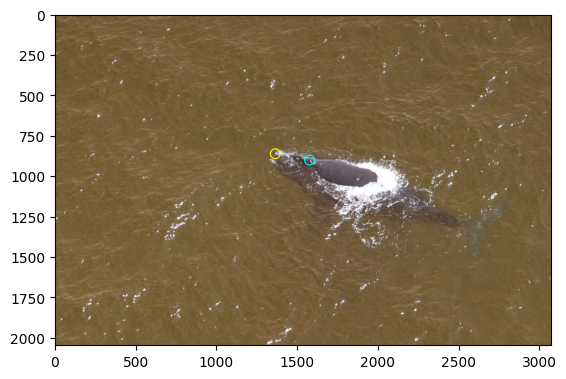

In [18]:
image_name = headtips[0]['filename']
x1 = int(headtips[0]['annotations'][0]['x'])
y1 = int(headtips[0]['annotations'][0]['y'])
x2 = int(blowholes[0]['annotations'][0]['x'])
y2 = int(blowholes[0]['annotations'][0]['y'])
image_path = os.path.join(image_dir, image_name)
prediction = rfh.get_prediction(image_path)
if prediction:
    image = cv2.imread(image_path)
    cv2.circle(image, (x1, y1), 30, color=(255,255,0), thickness=6)
    cv2.circle(image, (x2, y2), 30, color=(0,255,255), thickness=6)
    plt.imshow(image)

### Centre and Rotate Images

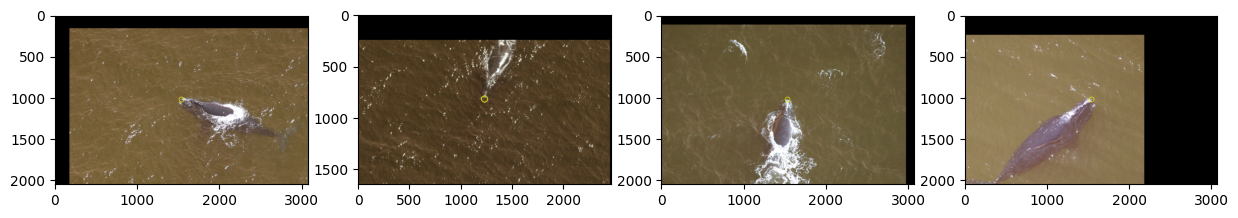

In [32]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    image_name = headtips[i]['filename']
    x1 = int(headtips[i]['annotations'][0]['x'])
    y1 = int(headtips[i]['annotations'][0]['y'])
    x2 = int(blowholes[i]['annotations'][0]['x'])
    y2 = int(blowholes[i]['annotations'][0]['y'])
    image_path = os.path.join(image_dir, image_name)
    image = cv2.imread(image_path)
    cv2.circle(image, (x1, y1), 30, color=(255,255,0), thickness=6)
    centred_image = centre_image(image, x1, y1)
    axes[i].imshow(centred_image)

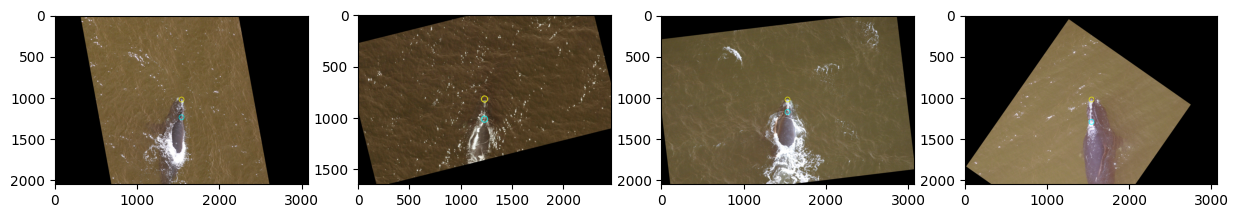

In [33]:
# Display the first four images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    image_name = headtips[i]['filename']
    x1 = int(headtips[i]['annotations'][0]['x'])
    y1 = int(headtips[i]['annotations'][0]['y'])
    x2 = int(blowholes[i]['annotations'][0]['x'])
    y2 = int(blowholes[i]['annotations'][0]['y'])
    image_path = os.path.join(image_dir, image_name)
    image = cv2.imread(image_path)
    
    rotation_angle = find_rotation_angle(x1, y1, x2, y2)
    cv2.circle(image, (x1, y1), 30, color=(255,255,0), thickness=6)
    cv2.circle(image, (x2, y2), 30, color=(0,255,255), thickness=6)
    centred_image = centre_image(image, x1, y1)
    rotated_image = rotate_image(centred_image, rotation_angle) 
    
    axes[i].imshow(rotated_image)

### Crop images

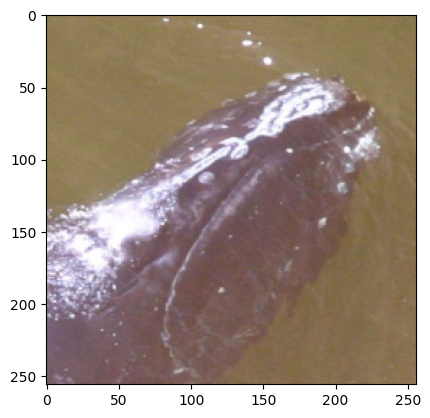

In [34]:
prediction = rfh.get_prediction(image_path)
if prediction:
    image = cv2.imread(image_path)
    start_point, end_point = calculate_bounding_box(prediction['x'], prediction['y'], prediction['width'], prediction['height'])
    cropped = crop_image(image, start_point, end_point)
    resized = cv2.resize(cropped, (256,256), interpolation = cv2.INTER_AREA)
    plt.imshow(resized)

### Further Image Preprocessing

Find an image with lot's of irritations

In [25]:
image_path = os.path.join(image_dir, "w_38.jpg")
prediction = rfh.get_prediction(image_path)
if prediction:
    image = cv2.imread(image_path)
    start_point, end_point = calculate_bounding_box(prediction['x'], prediction['y'], prediction['width'], prediction['height'])
    cropped = crop_image(image, start_point, end_point)
    resized = cv2.resize(cropped, (256,256), interpolation = cv2.INTER_AREA)

#### Dialation or Erosion

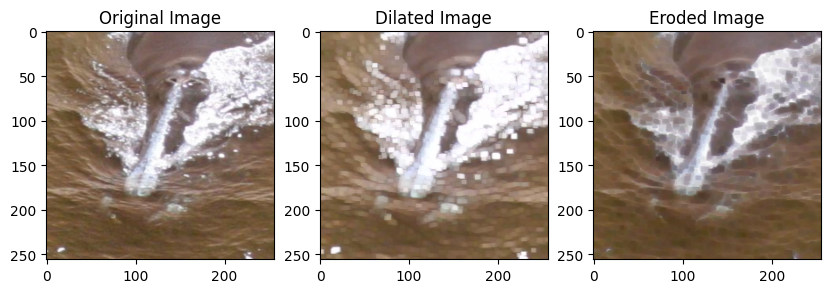

In [30]:
# Define the kernel for dilation
kernel = np.ones((4, 4), np.uint8)  # You can adjust the kernel size as needed

# Apply dilation
dilated_img = cv2.dilate(resized, kernel, iterations=1)
# Apply erosion
eroded_img = cv2.erode(resized, kernel, iterations=1)

# Display the original and dilated images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(resized, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Dialated Image')
plt.imshow(dilated_img, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Eroded Image')
plt.imshow(eroded_img, cmap='gray')


plt.show()

#### Sobel filter

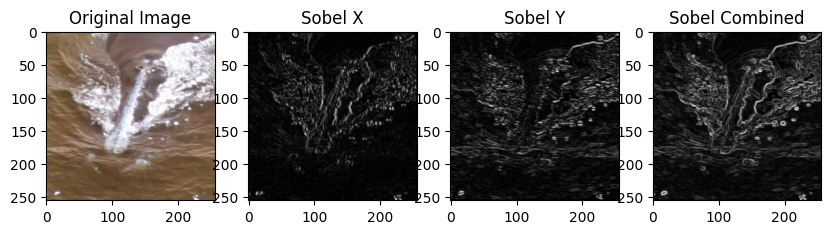

In [29]:
# Apply Sobel operator in the x direction
resized_gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

sobel_x = cv2.Sobel(resized_gray, cv2.CV_64F, 1, 0, ksize=3)

# Apply Sobel operator in the y direction
sobel_y = cv2.Sobel(resized_gray, cv2.CV_64F, 0, 1, ksize=3)

# Combine the results
sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)

# Display the original, Sobel x, Sobel y, and combined images
plt.figure(figsize=(10, 5))

plt.subplot(2, 4, 1)
plt.title('Original Image')
plt.imshow(resized, cmap='gray')

plt.subplot(2, 4, 2)
plt.title('Sobel X')
plt.imshow(np.abs(sobel_x), cmap='gray')

plt.subplot(2, 4, 3)
plt.title('Sobel Y')
plt.imshow(np.abs(sobel_y), cmap='gray')

plt.subplot(2, 4, 4)
plt.title('Sobel Combined')
plt.imshow(sobel_combined, cmap='gray')

plt.show()

## Prepare Testdata

In [13]:
# to not accidentally run the following code
throw Exception

SyntaxError: invalid syntax (2104500626.py, line 2)

### Testdata Creation Routines

In [ ]:
IMAGE_DIMENSIONS = (256,256)

### Rotations
Might be an overkill as the ANN should be able to learn without rotation

In [ ]:
input_path = "./data/imgs"
output_path = "./data/resized"

for i in range(len(headtips)):
    image_name = headtips[i]['filename']
    image_path = os.path.join(input_path, image_name)
    if os.path.exists(image_path):
        image = cv2.imread(image_path)
        resized = cv2.resize(image, IMAGE_DIMENSIONS, interpolation = cv2.INTER_AREA)
        cv2.imwrite(os.path.join(output_path, image_name), resized)

In [ ]:
input_path = "./data/resized"

rotation_angles = {}

for i in range(len(headtips)):
    image_name = headtips[i]['filename']
    image_path = os.path.join(input_path, image_name)
    if os.path.exists(image_path):
        x1 = int(headtips[i]['annotations'][0]['x'])
        y1 = int(headtips[i]['annotations'][0]['y'])
        x2 = int(blowholes[i]['annotations'][0]['x'])
        y2 = int(blowholes[i]['annotations'][0]['y'])
        if x1 and y1 and x2 and y2:
            rotation_angle = find_rotation_angle(x1, y1, x2, y2) - 180
            rotation_angles[image_name] = ("%.2f" % rotation_angle)


In [ ]:
angles = pd.Series(rotation_angles, name='rotation_angle')
angles.head(20)

In [ ]:
pd.Series(rotation_angles, name='rotation_angle').to_csv('./data/rotation_angles.csv')

In [ ]:
# Probably an overkill

input_path = "./data/imgs"
output_path = "./data/cropped"

for i in range(len(headtips)):
    image_name = headtips[i]['filename']
    image_path = os.path.join(input_path, image_name)
    if os.path.exists(image_path):
        image = cv2.imread(image_path)
        prediction = rfh.get_prediction(image_path)
        if prediction:
            image = cv2.imread(image_path)
            start_point, end_point = calculate_bounding_box(prediction['x'], prediction['y'], prediction['width'], prediction['height'])
            cropped = crop_image(image, start_point, end_point)
            resized = cv2.resize(cropped, IMAGE_DIMENSIONS, interpolation = cv2.INTER_AREA)
            cv2.imwrite(os.path.join(output_path, image_name), resized)

### Detection
Was also done manually one the cropped and resized images have been created.

In [ ]:
input_path = "./data/imgs"
output_path = "./data/rotated"

for i in range(len(headtips)):
    image_name = headtips[i]['filename']
    x1 = int(headtips[i]['annotations'][0]['x'])
    y1 = int(headtips[i]['annotations'][0]['y'])
    x2 = int(blowholes[i]['annotations'][0]['x'])
    y2 = int(blowholes[i]['annotations'][0]['y'])
    image_path = os.path.join(image_dir, image_name)
    if os.path.exists(image_path) and not os.path.exists(os.path.join(output_path, image_name))
        image = cv2.imread(image_path)
        if image is not None and x1 and y1 and x2 and y2:
            rotation_angle = find_rotation_angle(x1, y1, x2, y2)
            centred_image = centre_image(image, x1, y1)
            rotated_image = rotate_image(centred_image, rotation_angle) 
            cv2.imwrite(os.path.join(write_path, image_name), rotated_image)

In [ ]:
input_path = "./data/rotated"
output_path = "./data/rotated_cropped"

for i in range(len(headtips)):
    image_name = headtips[i]['filename']
    image_path = os.path.join(input_path, image_name)
    if os.path.exists(image_path):
        prediction = rfh.get_prediction(image_path)
        if prediction:
            image = cv2.imread(image_path)
            start_point, end_point = calculate_bounding_box(prediction['x'], prediction['y'], prediction['width'], prediction['height'])
            cropped = crop_image(image, start_point, end_point)
            resized = cv2.resize(cropped, IMAGE_DIMENSIONS, interpolation = cv2.INTER_AREA)
            cv2.imwrite(os.path.join(output_path, image_name), resized)

### Final Augmentations
The final augmentation we did:

- Gaussian blur with Kernel (2,2)
- Random rotations on the original images [-10°, +10°]